## Adaptive IMLE vs Vanilla IMLE
In this notebook, we showcase a very basic implementation for [Adaptive IMLE](paper_link) and [Vanilla IMLE](https://arxiv.org/abs/1809.09087) in 2D.

While Vanilla IMLE fails to cover all data examples even in this simple situation, Adaptive IMLE covers all data examples showing superior mode-coverage. 

In [20]:
import os
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import imageio
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import numpy as np
import seaborn as sns
import pandas as pd
from siren_pytorch import SirenNet
from torch.distributions import Beta

seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

### Generator
Here we define a simple generator consisting of a few fully connected layers. We initial its weight using standard Gaussian.

In [3]:
def init_weights(m):
    def truncated_normal_init(t, mean=0.0, std=0.5):
        torch.nn.init.normal_(t, mean=mean, std=std)
        while True:
            cond = torch.logical_or(t < mean - 2 * std, t > mean + 2 * std)
            if not torch.sum(cond):
                break
            t = torch.where(cond, torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std), t)
        return t
    

In [4]:
class Generator(nn.Module):
    def __init__(self, n_mlp=5, in_dim=32, out_dim=2, hidden_dim=128):
        super().__init__()
        assert(n_mlp >= 2)

        layers = [nn.Linear(in_dim, hidden_dim), nn.LeakyReLU(0.2)]
        for i in range(n_mlp - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.layers = nn.Sequential(*layers)
#         self.apply(init_weights)        


    def forward(self, latents):
        return self.layers(latents)

In [5]:
class Generator(nn.Module):
    def __init__(self, n_mlp=5, in_dim=32, out_dim=2, hidden_dim=128):
        super().__init__()
        assert(n_mlp >= 2)

        layers = [nn.Linear(in_dim, hidden_dim), nn.LeakyReLU(0.2)]
        for i in range(n_mlp - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.layers = nn.Sequential(*layers)
#         self.apply(init_weights)        


    def forward(self, latents):
        return self.layers(latents)

### Plotting function
We define a simple plotting function to visualize data examples and generated examples.

In [6]:
def plot_kde(generated, data_points, f_name, title):
    plt.clf()
    data = pd.DataFrame.from_dict({'x': generated[:, 0], 'y': generated[:, 1]})
    plt.figure(figsize=(8, 6))
    plt.ylim(-0.3, 0.4)
    plt.xlim(-0.35, 0.35)
    plt.title(title)
    plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue")
    sns.kdeplot(data=data, fill=True, levels=200, alpha=0.5, palette="rocket_r") 
    plt.savefig(f_name)
    plt.close()

    

def plot_nns(g, data_points, zs, selected_z, title=None, f_name=None, arrow=False, vanilla=False):
    generated = g(zs).detach()
    if(not vanilla):
        selected = g(selected_z).detach()
    plt.figure(figsize=(8, 6))
    # plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue", marker="s")
    plt.scatter(generated[:, 0], generated[:, 1], label="Generated samples", color="orange", alpha=0.4, marker=".")
    if(not vanilla):
        plt.scatter(selected[:, 0], selected[:, 1], label="Nearest neighbours", color="red",marker=".")

    if arrow:
        gen_to_data_vec = data_points - generated
        # unit_vecs = gen_to_data_vec / np.linalg.norm(gen_to_data_vec, axis=1)[:, None]
        plt.quiver(generated[:, 0], generated[:, 1], 0.19*gen_to_data_vec[:, 0], 0.19*gen_to_data_vec[:, 1],
                   color="black", scale_units="xy", angles='xy', scale=0.2, width=0.0015, headwidth=10, headlength=10, label="Nearest neighbour vectors")

    plt.legend()
    plt.title(title)
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    if f_name:
        plt.savefig(f_name)
        plt.close()
        #plot_kde(generated, data_points, f_name.replace(".png", "_kde.png"), title)
    else:
        plt.show()
        

def plot_final(g, data_points, zs, selected_z, title=None, f_name=None, arrow=False, vanilla=False):
    generated = g(zs).detach()
    if(not vanilla):
        selected = g(selected_z).detach()
    plt.figure(figsize=(8, 6))
    # plt.rcParams["figure.figsize"] = [7.50, 3.50]
    # plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue", marker="s")
    plt.scatter(generated[:, 0], generated[:, 1], label="Generated samples", color="orange", alpha=0.1, marker=".")
    if(not vanilla):
        plt.scatter(selected[:, 0], selected[:, 1], label="Nearest neighbours", color="red",marker=".")

    if arrow:
        gen_to_data_vec = data_points - generated
        # unit_vecs = gen_to_data_vec / np.linalg.norm(gen_to_data_vec, axis=1)[:, None]
        plt.quiver(generated[:, 0], generated[:, 1], 0.19*gen_to_data_vec[:, 0], 0.19*gen_to_data_vec[:, 1],
                   color="black", scale_units="xy", angles='xy', scale=0.2, width=0.0015, headwidth=10, headlength=10, label="Nearest neighbour vectors")

    plt.legend()
    plt.title(title)
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    if f_name:
        plt.savefig(f_name)
        plt.close()
        #plot_kde(generated, data_points, f_name.replace(".png", "_kde.png"), title)
    else:
        plt.show()

### Hyperparameters
Here we defined a few hyperparameters.

In [36]:
zdim = 32  # latent space dimension

# Dataset
Here we consider some 2D data examples defined by _data\_points_. We create a generator object and visualize some generated samples.

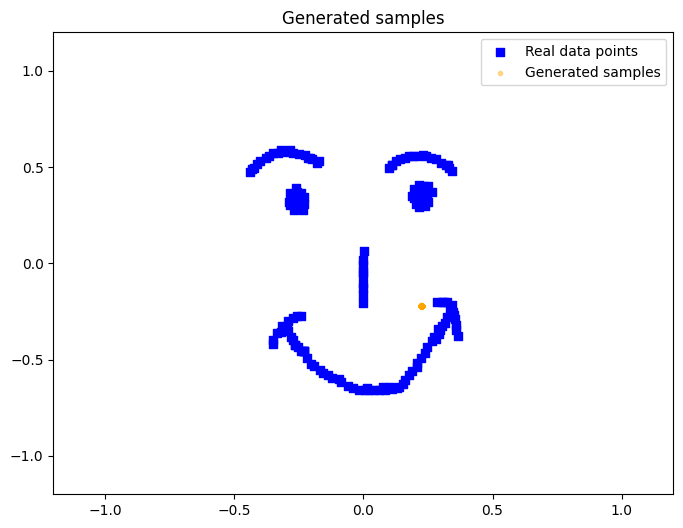

In [39]:
g = Generator(n_mlp=5, in_dim=zdim, hidden_dim=16)
# g = GeneratorLehsun(n_mlp=4, in_dim=zdim)
# data_points = torch.tensor([
#         [-0.1257,  0.3797],
#         [-0.1573,  0.1287],
#         [ 0.1076,  0.0971],
#         [ 0.1443,  0.1333],
#         [-0.1243,  0.1533],
#         [-0.0321,  0.1898],
#         [ 0.1347, -0.1573],
#         [-0.3069,  0.2949],
#         [ 0.0202,  0.1158],
#         [ 0.3023,  0.3158],
#         [ 0.2379, -0.2279],
#         [-0.2379, -0.2279],
#         [-0.0295,  0.0197],
#         [ 0.0853, -0.0708]])

data_points = torch.load("smiley.pt")

data_points -= torch.mean(data_points, 0)
data_points /= torch.tensor([20,10])

n = data_points.shape[0]
nz = data_points.shape[0]*10  # pool size
zs = torch.randn(nz, zdim)

plot_nns(g, data_points, zs, None, title="Generated samples", vanilla=True)

In [9]:
lr = 0.01  # learning rate
epochs = 10000  # number of epochs for training
tau=0.85  # tightening threshold defined in the Adaptive IMLE paper
noise_coef = 0.000001  # additive noise coeficient
staleness = 1000  # staleness for Vanilla IMLE

### Nearest Neighbours
Here we define a naive function to find nearest neighbour of each data example. This nearest neighbour part can be vastly optimized using [DCI](https://arxiv.org/abs/1703.00440).

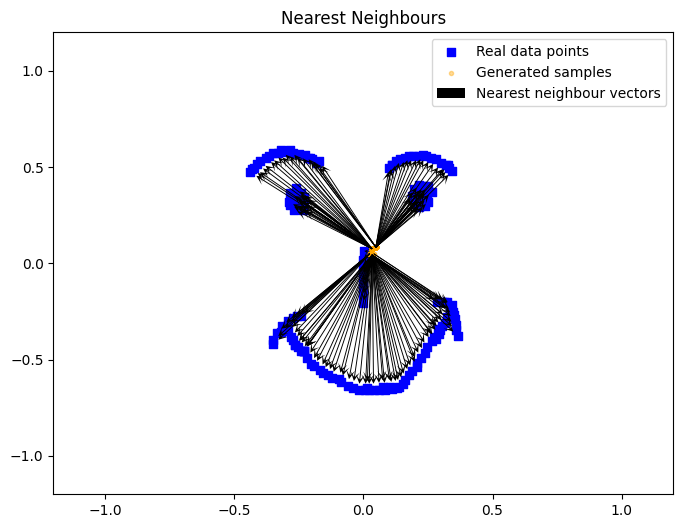

In [10]:
def find_nn(data_point, generated):
    dists = torch.sum((generated - data_point)**2, dim=1)
    dists = dists**0.5
    return torch.argmin(dists).item()

def find_nn_new(data_point, generated, limit = 1e-3):
    dists = torch.sum((generated - data_point)**2, dim=1)
    dists = dists**0.5
    to_update = dists < limit
    dists[to_update] = np.inf
    return torch.argmin(dists).item()

def find_nn_k(data_point, generated, k = 3):
    dists = torch.sum((generated - data_point)**2, dim=1)
    dists = dists**0.5
    least_k = torch.topk(dists, k, sorted=True, largest=False)
    return least_k.indices[k-1]

generated = g(zs).detach()
nns = [find_nn(data_points[i], generated) for i in range(n)]

plot_nns(g, data_points, zs[nns], None, title="Nearest Neighbours", arrow=True, vanilla=True)

### Vanilla IMLE implementation
Here we implement a basic version of Vanilla IMLE.

In [40]:
imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(imle_g.parameters(), lr=lr)
imle_nn_z = torch.randn(n, zdim)
epochs = 30000
staleness = 25
plot_staleness = 5000
nz = data_points.shape[0]*10


for e in tqdm(range(epochs)):
    with torch.no_grad():
        if e % staleness == 0:
            zs = torch.randn(nz, zdim)
            generated = imle_g(zs).detach()
            nns = torch.tensor([find_nn(d, generated) for d in data_points], dtype=torch.long)
            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef
        if e % plot_staleness == 0:
            plot_final(imle_g, data_points, zs, None, title=f"Epoch {e}", f_name=f"plots_mixup_smiley/epoch-{e}.png", arrow=False, vanilla=True)

    optim.zero_grad()
    outs = imle_g(imle_nn_z)
    dists = torch.sum((outs - data_points)**2, dim=1)
    loss = dists.mean()
    loss.backward()
    optim.step()



nz_fake = data_points.shape[0]*10
zs = torch.randn(nz_fake, zdim)
plot_final(imle_g, data_points, zs, None, title="Vanilla IMLE new distance", f_name=f"plots_mixup_smiley/imle-final-{staleness}.png", arrow=False, vanilla=True)


# with imageio.get_writer(f'imle_training_kde.gif', mode='I') as writer:
#     for e in range(0,epochs,staleness):
#         filename = f"plots/epoch-{e}_kde.png"
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

100%|██████████| 30000/30000 [00:26<00:00, 1143.86it/s]


## Mixup Distance

In [13]:
def find_nn_improved(data_point, generated, limit = 1e-3,print_results=False):
    l2_distances = np.linalg.norm(generated[:, np.newaxis] - data_point , axis=2)
    to_exclude = l2_distances < limit
    bad_samples_list = np.expand_dims(to_exclude.any(axis=1),-1)
    bad_samples_list_repeated = np.tile(bad_samples_list,to_exclude.shape[1])
    l2_distances[bad_samples_list_repeated] = np.inf
    result = np.argmin(l2_distances,axis=0)
    return result

In [23]:
alpha = 0.3


tensor([7.4551e-04, 3.7896e-01, 5.5877e-01, 8.8188e-02, 9.3042e-01, 3.5406e-02,
        8.7431e-03, 5.8502e-01, 7.4632e-08, 1.0173e-03, 6.4618e-01, 9.8553e-01,
        2.8688e-01, 2.9333e-01, 3.0278e-01, 9.9778e-01, 3.5711e-01, 9.5780e-02,
        4.6224e-03, 9.1348e-01, 3.0629e-01, 9.3932e-01, 5.0288e-01, 6.7791e-01,
        9.8259e-01, 9.9279e-01, 1.6671e-02, 9.9956e-01, 9.2152e-01, 7.1146e-01,
        6.6617e-01, 5.6435e-05, 9.7632e-01, 1.3436e-01, 9.9873e-01, 8.7056e-01,
        1.3055e-06, 6.6999e-01, 2.5237e-02, 6.9539e-01, 2.0631e-01, 1.1888e-01,
        1.4254e-03, 5.2639e-01, 9.4652e-05, 1.2623e-01, 6.2696e-01, 9.7218e-01,
        8.8085e-01, 8.4955e-01, 9.4481e-01, 9.9971e-01, 7.2966e-02, 7.6242e-01,
        2.6277e-01, 3.9808e-02, 9.9993e-01, 7.2260e-03, 4.7629e-01, 9.8438e-01,
        5.1061e-01, 2.5040e-02, 8.8176e-01, 1.9904e-01, 4.5824e-04, 9.3192e-01,
        2.7575e-01, 9.9998e-01, 8.8696e-01, 9.1200e-01, 3.5697e-01, 9.9316e-01,
        9.0133e-01, 1.3081e-01, 9.1085e-

In [47]:
improved_imle_g = copy.deepcopy(g)
optim = torch.optim.Adam(improved_imle_g.parameters(), lr=lr)
imle_nn_z = torch.randn(n, zdim)
epochs = 30000
staleness = 25
plot_staleness = 5000
factor = 10
nz = data_points.shape[0]*factor
alpha = 0.05
beta = Beta(alpha, alpha)


for e in tqdm(range(epochs)):
    with torch.no_grad():
        if e % staleness == 0:
            zs = torch.randn(nz, zdim)
            generated = improved_imle_g(zs).detach()
            nns = torch.tensor([find_nn(d, generated) for d in data_points], dtype=torch.long)
            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef
        if e % plot_staleness == 0:
            plot_final(improved_imle_g, data_points, zs, None, title=f"Epoch {e}", f_name=f"plots_mixup_smiley/mixup-epoch-{e}.png", arrow=False, vanilla=True)

    lam = beta.rsample((n,1))
    # print(lam.shape)
    lam_binary = lam > 0.5
    index = np.random.permutation(n)

    mixed_batch_x = lam * imle_nn_z + (1 - lam) * imle_nn_z[index]
    mixed_batch_y = lam_binary * data_points + (torch.logical_not(lam_binary)) * data_points[index]

    optim.zero_grad()
    outs = improved_imle_g(mixed_batch_x)
    dists = torch.sum((outs - mixed_batch_y)**2, dim=1)
    loss = dists.mean()
    loss.backward()
    optim.step()



nz_fake = data_points.shape[0]*10
zs = torch.randn(nz_fake, zdim)
plot_final(improved_imle_g, data_points, zs, None, title="Mixup IMLE", f_name=f"plots_mixup_smiley/mixup-imle-final-{staleness}-{alpha}.png", arrow=False, vanilla=True)


100%|██████████| 30000/30000 [00:30<00:00, 991.04it/s] 


: 

In [51]:
anchors = torch.zeros(n, zdim)
for i in range(n):
    anchors[i][i] = 1

### Visualizing results
Here we visualize nearest neighbour of each data example among randomly generated samples after training. We can see that Vanilla IMLE fails to cover the left-most and right-most data examples while Adaptive IMLE succeeds in covering all data examples the same.

In [ ]:
nz = 500  # number of generated samples

zs = torch.randn(nz, zdim)
generated = ada_imle_g(zs).detach()
nns = [find_nn(data_points[i], generated) for i in range(n)]
plot_nns(ada_imle_g, data_points, zs[nns], title=f"Adaptive IMLE results", arrow=True)

generated = imle_g(zs).detach()
nns = [find_nn(data_points[i], generated) for i in range(n)]
plot_nns(imle_g, data_points, zs[nns], title=f"IMLE results", arrow=True)

In [ ]:
# generated = generated.detach().numpy()
# sns.kdeplot(data={'x': generated[:, 0], 'y': generated[:, 1]}, x="x", y="y", fill=True, alpha=1., cmap='rocket_r', levels=30) 
generated = imle_g(zs).detach().numpy()
data = pd.DataFrame.from_dict({'x': generated[:, 0], 'y': generated[:, 1]})
plt.figure(figsize=(8, 6))
plt.ylim(-0.3, 0.4)
plt.xlim(-0.35, 0.35)
plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue")
sns.kdeplot(data=data, fill=True, alpha=1., palette='rocket_r', levels=30, multiple="fill") 
plot_nns(imle_g, data_points, zs, title=f"IMLE results")


In [ ]:
generated = ada_imle_g(zs).detach().numpy()
data = pd.DataFrame.from_dict({'x': generated[:, 0], 'y': generated[:, 1]})
plt.figure(figsize=(8, 6))
plt.ylim(-0.3, 0.4)
plt.xlim(-0.35, 0.35)
plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue")
sns.kdeplot(data=data, fill=True, alpha=1.0, palette='rocket_r', levels=30) 
plot_nns(ada_imle_g, data_points, zs, title=f"IMLE results")
